In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("Cleaned_tweets.csv")

In [4]:
data['Text'] = data['Text'].astype(str)
data.head()

,Unnamed: 0,Key Word,Username,User_ID,Datetime,Favorite_count,Geo,Coordinates,Label,Text,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,704,ass,DeborahParr,1.330000e+18,11-11-2020 06:56,0,NaN,NaN,1,He’d have my phone wedged up his ass sideways.,NaN,NaN,NaN
1,1915,boobies,MaxZorin85,1.330000e+18,11-11-2020 07:35,4,NaN,NaN,0,Yep 100% agree and the same with severine in s...,NaN,NaN,NaN
2,2856,eat pussy,PRISJ1_,1.330000e+18,11-11-2020 10:36,0,NaN,NaN,1,Stop having sex with men that won’t eat your p...,NaN,NaN,NaN
3,2163,Breast Man,Teresamckenzy1,1.330000e+18,10-11-2020 20:52,0,NaN,NaN,1,"When you see a sad man, just give him breast t...",NaN,NaN,NaN
4,2852,eat pussy,sj__vazquez,1.330000e+18,11-11-2020 10:42,0,NaN,NaN,1,We can't be together if you don't eat pussy,NaN,NaN,NaN


In [5]:
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics

In [6]:
!pip3 install bert-for-tf2

     |████████████████████████████████| 51kB 5.2MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=2662f378d7eaaeab1436ad33b4a7828aac24578daf47874b271c97402cd9dfb1
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=c86e32841086bd75655ac24cbffea9e19c4e33ef53068200a0bdb8698fec713b
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=d21366a7fe0e68b931f6b75c1b1d0bd56e1e4058fc13119def4bae380fcd6946
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [7]:
import tensorflow_hub as hub 
from bert import bert_tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [8]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(data.Text, data['Label'], 
                                                                          test_size=0.2, random_state=0)
# print(X_train['Text'])
# X_train['Text'] = X_train['Text'].apply(lambda x : string(x))
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

In [11]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [12]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    X_train, y_train, 
   
    epochs=5,
    callbacks=[checkpoint, earlystopping],
    batch_size=1,
    verbose=1
)

Epoch 1/5
2883/2883 [==============================] - 182s 58ms/step - loss: 0.6115 - accuracy: 0.6579


Epoch 2/5
2883/2883 [==============================] - 167s 58ms/step - loss: 0.3356 - accuracy: 0.8740


Epoch 3/5
2883/2883 [==============================] - 167s 58ms/step - loss: 0.2040 - accuracy: 0.9410


Epoch 4/5
2883/2883 [==============================] - 166s 58ms/step - loss: 0.0940 - accuracy: 0.9727


Epoch 5/5
2883/2883 [==============================] - 166s 58ms/step - loss: 0.0781 - accuracy: 0.9789


CPU times: user 9min 36s, sys: 3min 51s, total: 13min 27s
Wall time: 14min 9s


In [13]:
train_history.history

{'accuracy': [0.7159209251403809,
  0.8616024851799011,
  0.9354838728904724,
  0.9684356451034546,
  0.974679172039032],
 'loss': [0.5518959164619446,
  0.3433631360530853,
  0.19876554608345032,
  0.10605648159980774,
  0.08444732427597046]}

In [14]:
print(X_val[0])

[[  101  2016  2018 ...     0     0     0]
 [  101  1045  2066 ...     0     0     0]
 [  101 10587  5610 ...     0     0     0]
 ...
 [  101 10334  5026 ...     0     0     0]
 [  101  1043  2546 ...     0     0     0]
 [  101  6289  1010 ...     0     0     0]]


In [15]:
test_performance=model.evaluate(X_val,y_val)
print((test_performance))
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))
y_pred = model.predict(X_val)

23/23 [==============================] - 6s 221ms/step - loss: 0.7269 - accuracy: 0.8336
[0.7269390225410461, 0.8335645198822021]
The loss of the model on the test set : 0.7269390225410461
The accuracy of the model on the test set : 83.35645198822021%


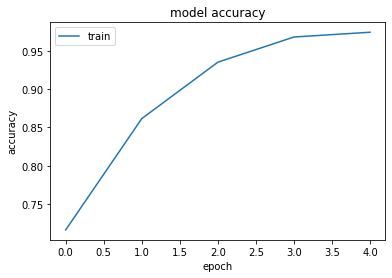

In [16]:
plt.plot(train_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

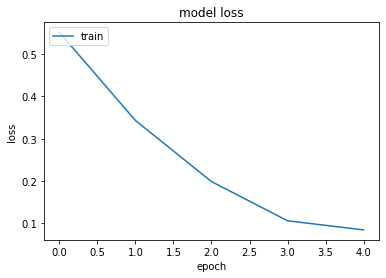

In [17]:
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
new_input = ["bite me in the ass"]

new_val = bert_encode(new_input, tokenizer, max_len=max_len)

print(model.predict(new_val))

[[0.9999174]]


In [ ]:
y_pred = np.round(y_pred)

In [29]:
from sklearn.metrics import f1_score
print(f1_score(y_val, y_pred, average='macro'))
print(f1_score(y_val, y_pred, average='micro'))
print(f1_score(y_val, y_pred, average='weighted'))
print(f1_score(y_val, y_pred, average=None))
print(f1_score(y_val, y_pred, zero_division=1))

0.830623942867882
0.8335644937586685
0.8326358987405255
[0.80830671 0.85294118]
0.8529411764705882


In [30]:
from sklearn.metrics import recall_score
print(recall_score(y_val, y_pred, average='macro'))
print(recall_score(y_val, y_pred, average='micro'))
print(recall_score(y_val, y_pred, average='weighted'))
print(recall_score(y_val, y_pred, average=None))
print(recall_score(y_val, y_pred, average=None, zero_division=1))

0.8284188233103705
0.8335644937586685
0.8335644937586685
[0.77134146 0.88549618]
[0.77134146 0.88549618]


In [31]:
from sklearn.metrics import precision_score
print(precision_score(y_val, y_pred, average='macro'))
print(precision_score(y_val, y_pred, average='micro'))
print(precision_score(y_val, y_pred, average='weighted'))
print(precision_score(y_val, y_pred, average=None))
print(precision_score(y_val, y_pred, average=None, zero_division=1))

0.8358441620257985
0.8335644937586685
0.8346587345268909
[0.84899329 0.82269504]
[0.84899329 0.82269504]
